In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import asymmetric_processes
from asymmetric_processes import CircleProcess, BoundaryProcess, State
import matplotlib.pyplot as plt
import seaborn as sns # comment out if you don't have installed

In [3]:
reload(asymmetric_processes)

<module 'asymmetric_processes' from 'asymmetric_processes.pyc'>

In [4]:
import scipy.sparse as sparse

# Intro to `State` and `CircleProcess`

The `State` class helps find "open spots to right" and other information about a state. 

The `CircleProcess` class enumerates the possible states, and determines the state transitions

In [10]:
# New process object
N = 5
k = 2
q = 0.
p = CircleProcess(N, k, q)

One thing `CircleProcess` does is map states into integers.

In [11]:
print '11100', ":", p.state_index('11100')
print '11010', ":", p.state_index('11010')
print '01110', ":", p.state_index('01110')
print '00111', ":", p.state_index('00111')

11100 : 0
11010 : 1
01110 : 6
00111 : 9


In [12]:
all_states = p.enum_states()
dict(zip(all_states, range(len(all_states))))

{'00011': 9,
 '00101': 8,
 '00110': 7,
 '01001': 6,
 '01010': 5,
 '01100': 4,
 '10001': 3,
 '10010': 2,
 '10100': 1,
 '11000': 0}

It also runs simulations

In [13]:
# A single simulation
sim = p.run_sim(20, [1, 1, 0, 0, 0])
sim

array([[ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  1.]])

In [17]:
# Many simulations, averaging over all to get distribution
sim = p.run_sims(1000, 50, [1, 1, 0, 0, 0])
dist = np.mean(sim, axis=0)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


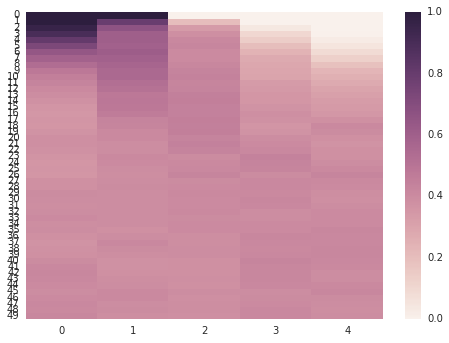

In [19]:
sns.heatmap(dist);

# Transition Matrices and Exact Calculation

As you can see above, we get some variance in the simulated distribution over time, and we can't make many analytical conclusions. 

Below we see how transitions are combined into transition matrix `T`.

In [20]:
p.transitions(State('11100'))

{'11010': 0.2, '11100': 0.8}

In [21]:
p.transitions(State('10100'))

{'01100': 0.2, '10010': 0.2, '10100': 0.6}

In [22]:
p.transitions(State('10001'))

{'01001': 0.2, '10001': 0.8}

In [24]:
S, T = p.matrices()

In [25]:
S # N x M matrix of states

array([[ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.]])

In [26]:
T.todense() # M x M matrix of transitions

matrix([[ 0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ,  0. ,  0. ],
        [ 0.2,  0.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ],
        [ 0. ,  0.2,  0.6,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2],
        [ 0. ,  0. ,  0.2,  0.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0.2,  0. ,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0.2,  0. ,  0.2,  0.6,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0.2,  0. ,  0.2,  0.6,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ,  0.8,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0.2,  0.6,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0.8]])

With this, propagate the probabilities exactly. 

In [28]:
M = T.shape[0]
x = np.zeros(M)
x[0] = 1
print "Pick just one state:", x
print "Corresponding to sequence:", State(S.dot(x))

Pick just one state: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Corresponding to sequence: 11000


In [29]:
iters = 50
R = np.zeros((iters, N))
for i in range(iters):
    print " ".join(["%.4f" % s for s in S.dot(x)])
    R[i] = S.dot(x)
    x = T.dot(x)

1.0000 1.0000 0.0000 0.0000 0.0000
1.0000 0.8000 0.2000 0.0000 0.0000
0.9600 0.6800 0.3200 0.0400 0.0000
0.8960 0.6160 0.3840 0.0960 0.0080
0.8192 0.5872 0.4128 0.1536 0.0272
0.7382 0.5776 0.4224 0.2048 0.0570
0.6598 0.5759 0.4237 0.2461 0.0944
0.5889 0.5750 0.4234 0.2770 0.1358
0.5283 0.5710 0.4244 0.2988 0.1775
0.4796 0.5624 0.4277 0.3137 0.2166
0.4426 0.5493 0.4329 0.3242 0.2511
0.4162 0.5330 0.4387 0.3321 0.2800
0.3988 0.5147 0.4443 0.3391 0.3031
0.3884 0.4961 0.4485 0.3461 0.3209
0.3830 0.4784 0.4510 0.3533 0.3342
0.3811 0.4625 0.4514 0.3610 0.3440
0.3812 0.4488 0.4500 0.3688 0.3513
0.3823 0.4376 0.4470 0.3763 0.3569
0.3837 0.4287 0.4429 0.3833 0.3615
0.3850 0.4219 0.4382 0.3894 0.3655
0.3860 0.4167 0.4333 0.3945 0.3694
0.3868 0.4129 0.4286 0.3986 0.3731
0.3874 0.4101 0.4242 0.4016 0.3767
0.3879 0.4080 0.4203 0.4036 0.3802
0.3884 0.4063 0.4170 0.4049 0.3835
0.3889 0.4049 0.4142 0.4055 0.3865
0.3895 0.4036 0.4120 0.4057 0.3892
0.3902 0.4026 0.4101 0.4056 0.3915
0.3910 0.4017 0.4086

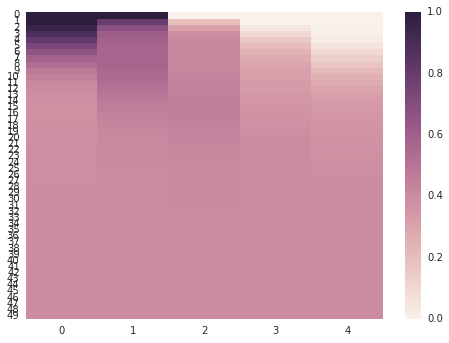

In [30]:
sns.heatmap(R);

# Eigenvalue Analysis

By looking at eigenvalues/vectors of `T`, we can understand which patterns in distribution die away faster than others.

In [31]:
l, v = np.linalg.eig(T.todense())

There are 10 eigenvalues since there are 10 states. One of them is 1., with no imaginary part. This is the steady state. The others have imaginary parts, corresponding so some kind of oscillation at various frequencies. The magnitudes tell how quickly the eigenvector, or "mode," decays.

In [32]:
zzz = sorted(zip(range(len(l)), np.abs(l), np.angle(l, deg=True)), key=lambda x: -x[1])
print "EIGENVALUES"
print "IDX  MAG       ANGLE"
for i, m, a in zzz:
    print "%s" % i, "   %.4f    %+.3f°" % (m, a)

EIGENVALUES
IDX  MAG       ANGLE
4    1.0000    +0.000°
5    0.8604    +4.358°
6    0.8604    -4.358°
2    0.8107    +20.835°
3    0.8107    -20.835°
8    0.7109    +7.937°
9    0.7109    -7.937°
7    0.6000    +0.000°
0    0.4220    +25.692°
1    0.4220    -25.692°


Below is the steady state. We can see all states are represented equally. The steady state is uniform probability over all. 

In [33]:
i = 4
print "EIG:", "\t%.4f\t%+.4f°" % (np.abs(l[i]), np.angle(l[i], deg=True))
print
print "STATE   MAG       ANGLE"
zzz = zip(p.enum_states(), np.array(v[:, i].transpose())[0].transpose())
zzz = sorted(zzz, key=lambda x: np.angle(x[1]))
for s, val in zzz:
    print s, "\t", "%.4f\t%+.3f°" % (np.abs(val), np.angle(val, deg=True))

EIG: 	1.0000	+0.0000°

STATE   MAG       ANGLE
11000 	0.3162	+180.000°
10100 	0.3162	+180.000°
10010 	0.3162	+180.000°
10001 	0.3162	+180.000°
01100 	0.3162	+180.000°
01010 	0.3162	+180.000°
01001 	0.3162	+180.000°
00110 	0.3162	+180.000°
00101 	0.3162	+180.000°
00011 	0.3162	+180.000°


The eigenvector below is the 2nd eigenvector, which decays the most slowly. Since it has an eigenvalue with imaginary part 4.3°, this eigenvector corresponding to looping through this sequence every ~60 iterations. 

This mode corresponds to the right 1 moving forward, then the left one moving 1 forward to catch up to it. This pattern COULD sustain itself forever (thats why its an eigenvector) but the probability will spread out and this pattern will decay quickly. 

In [34]:
i = 6
print "EIG:", "\t%.4f\t%+.4f°" % (np.abs(l[i]), np.angle(l[i], deg=True))
print
print "STATE   MAG       ANGLE"
zzz = zip(p.enum_states(), np.array(v[:, i].transpose())[0].transpose())
zzz = sorted(zzz, key=lambda x: np.angle(x[1]))
for s, val in zzz:
    print s, "\t", "%.4f\t%+.4f°" % (np.abs(val), np.angle(val, deg=True))

EIG: 	0.8604	-4.3578°

STATE   MAG       ANGLE
01100 	0.4098	-144.0000°
01010 	0.1790	-120.4512°
00110 	0.4098	-72.0000°
00101 	0.1790	-48.4512°
00011 	0.4098	-0.0000°
10010 	0.1790	+23.5488°
10001 	0.4098	+72.0000°
01001 	0.1790	+95.5488°
11000 	0.4098	+144.0000°
10100 	0.1790	+167.5488°


It's complex conjugate corresponds to rotating the opposite direction

In [35]:
i = 5
print "EIG:", "\t%.4f\t%+.4f°" % (np.abs(l[i]), np.angle(l[i], deg=True))
print
print "STATE   MAG       ANGLE"
zzz = zip(p.enum_states(), np.array(v[:, i].transpose())[0].transpose())
zzz = sorted(zzz, key=lambda x: np.angle(x[1]))
for s, val in zzz:
    print s, "\t", "%.4f\t%+.4f°" % (np.abs(val), np.angle(val, deg=True))

EIG: 	0.8604	+4.3578°

STATE   MAG       ANGLE
10100 	0.1790	-167.5488°
11000 	0.4098	-144.0000°
01001 	0.1790	-95.5488°
10001 	0.4098	-72.0000°
10010 	0.1790	-23.5488°
00011 	0.4098	+0.0000°
00101 	0.1790	+48.4512°
00110 	0.4098	+72.0000°
01010 	0.1790	+120.4512°
01100 	0.4098	+144.0000°


The last eigenvector is not really intuitive, and it decays the most quickly. It alternates between the 1s being right next to each other, and the 1s being two apart as if both moved to the right and left respectively. A reminder that these eigenvectors shouldn't be taken super literally.

In [36]:
i = 0
print "EIG:", "\t%.4f\t%+.4f°" % (np.abs(l[i]), np.angle(l[i], deg=True))
print
print "STATE   MAG       ANGLE"
zzz = zip(p.enum_states(), np.array(v[:, i].transpose())[0].transpose())
zzz = sorted(zzz, key=lambda x: np.angle(x[1]))
for s, val in zzz:
    print s, "\t", "%.4f\t%+.4f°" % (np.abs(val), np.angle(val, deg=True))

EIG: 	0.4220	+25.6917°

STATE   MAG       ANGLE
01100 	0.1790	-156.4512°
10010 	0.4098	-144.0000°
00110 	0.1790	-84.4512°
01001 	0.4098	-72.0000°
00011 	0.1790	-12.4512°
10100 	0.4098	+0.0000°
10001 	0.1790	+59.5488°
01010 	0.4098	+72.0000°
11000 	0.1790	+131.5488°
00101 	0.4098	+144.0000°
